In [1]:
import torch
import numpy as np
import pandas as pd
import glob
import os
import pickle

from tqdm import tqdm
from pathlib import Path
from sklearn.pipeline import Pipeline
from torchsummary import summary

from pymo.preprocessing import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
class EmotionsMovementsDataset(torch.utils.data.Dataset):
    def __init__(self, records_path, transform_pipeline=None, fit_transform=False, signal_len=120):
        records_path = Path(records_path)
        self.root_path = records_path.parent
        self.signals_list = pd.read_csv(records_path)   
        self.transform_pipeline = transform_pipeline
        self.signal_len=signal_len
        
        if self.transform_pipeline is not None and fit_transform:
            self.__fit_transform_pipeline()
        
    def __fit_transform_pipeline(self):
        data = [self.__getrawitem(i)[0] for i in range(len(self))]
        self.transform_pipeline.fit(data)
    
    def __getrawitem(self, idx):
        signal_metadata = self.signals_list.iloc[idx]
        signal_id, signal_label = signal_metadata['id'], signal_metadata['label']
        with open(Path(self.root_path, signal_id + '.pkl'), 'rb') as fd:
            bvh_position = pickle.load(fd)
        return bvh_position, signal_metadata['label']
        
    def __len__(self):
        return self.signals_list.shape[0]
    
    def __getitem__(self, idx):
        X, signal_label = self.__getrawitem(idx)

        if self.transform_pipeline is not None:
            X = self.transform_pipeline.transform([X])[0].astype(np.float32)
            
        X = X[-self.signal_len:, :] # get last signal_len timestemps
        # pad if needed in the beginning
        if X.shape[0] < self.signal_len:
            X = np.pad(X, ((self.signal_len - X.shape[0], 0), (0, 0)), mode='edge')        
        
        return torch.from_numpy(X), signal_label

In [3]:
transform_pipeline = Pipeline([
    ('rcpn', RootCentricPositionNormalizer()),
    ('delta', RootTransformer('abdolute_translation_deltas')),
    ('const', ConstantsRemover()),
#     ('selector', JointSelector(['Spine', 'RightFoot', 'LeftFoot', 'Head', 'RightForeArm', 'LeftForeArm'], include_root=True)),
    ('np', Numpyfier()),
    ('down', DownSampler(10)),
    ('stdscale', ListStandardScaler())
])

train_ds = EmotionsMovementsDataset(
    '/datasets/extra_space2/ostap/kinematic-dataset-of-actors-expressing-emotions-2.1.0/PyMO_output/train.csv',
    transform_pipeline=transform_pipeline,
    fit_transform=True
)
print('Transform fitted!')
val_ds = EmotionsMovementsDataset(
    '/datasets/extra_space2/ostap/kinematic-dataset-of-actors-expressing-emotions-2.1.0/PyMO_output/val.csv',
    transform_pipeline=train_ds.transform_pipeline,
    fit_transform=False
)
test_ds = EmotionsMovementsDataset(
    '/datasets/extra_space2/ostap/kinematic-dataset-of-actors-expressing-emotions-2.1.0/PyMO_output/test.csv',
    transform_pipeline=train_ds.transform_pipeline,
    fit_transform=False
)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=10)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=10, shuffle=False, num_workers=10)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=10, shuffle=False, num_workers=10)
X_sample = train_ds[0]

Transform fitted!


### Basic LSTM model

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

In [16]:
class EmotionLSTMBasic(nn.Module):
    def __init__(self, input_size, lstm_hidden_size, fc_hidden_size, output_size):
        super().__init__()
        self.lstm_layer = nn.LSTM(input_size, hidden_size=lstm_hidden_size, batch_first=True, num_layers=2)
        self.fc = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(lstm_hidden_size, fc_hidden_size)),
            ('fc2', nn.Linear(fc_hidden_size, output_size))
        ]))
    
    def forward(self, x):
        lstm_out, _ = self.lstm_layer(x)
        return self.fc(lstm_out[:, -1, :])

In [17]:
model = EmotionLSTMBasic(input_size=216, lstm_hidden_size=256, fc_hidden_size=512, output_size=7)

In [29]:
sum(list(map(lambda x: x.numel(), list(model.parameters()))))

1679879

In [7]:
x = next(iter(train_dl))
print(x[0].shape)
model(x[0]).shape

torch.Size([10, 120, 216])


torch.Size([10, 7])

In [27]:
class EmotionConvBasic(nn.Module):
    def __init__(self, in_channels, output_size):
        super().__init__()
        self.output_size = output_size
        self.conv_layers = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv1d(in_channels, 256, kernel_size=3, padding=1, dilation=5)),
            ('relu1', nn.ReLU(inplace=True)),
            ('bn1', nn.BatchNorm1d(256)),
            
            ('conv2', nn.Conv1d(256, 256, kernel_size=3, padding=1, dilation=5)),
            ('relu2', nn.ReLU(inplace=True)),
            ('bn2', nn.BatchNorm1d(256)),
            ('pool2', nn.MaxPool1d(kernel_size=2, stride=2)),
            
            ('conv3', nn.Conv1d(256, 512, kernel_size=3, padding=1, dilation=3)),
            ('relu3', nn.ReLU(inplace=True)),
            ('bn3', nn.BatchNorm1d(512)),
            
            ('conv6', nn.Conv1d(512, 512, kernel_size=3, padding=1, dilation=3)),
            ('relu6', nn.ReLU(inplace=True)),
            ('bn6', nn.BatchNorm1d(512)),
            ('pool6', nn.MaxPool1d(kernel_size=2, stride=2)),
        ]))
        
        self.fc = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(512, 256)),
            ('relu1', nn.ReLU(inplace=True)),
#             ('fc2', nn.Linear(256, 256)),
#             ('relu2', nn.ReLU(inplace=True)),
            ('fc3', nn.Linear(256, self.output_size)),
        ]))
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv_layers(x)
        x = x.mean(dim=2) # global average pooling
        return self.fc(x)

In [28]:
model = EmotionConvBasic(in_channels=216, output_size=7)

In [18]:
summary(model, input_size=(120, 216), batch_size=10, device='cpu')

AttributeError: 'tuple' object has no attribute 'size'

In [8]:
x = next(iter(train_dl))
print(x[0].shape)
model(x[0]).shape

torch.Size([10, 120, 216])


torch.Size([10, 7])

### Train loop

In [11]:
device = torch.device('cuda:1')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

In [10]:
@torch.no_grad()
def test(model, test_dl, criterion, device):
    model.eval()
    batch_loss = []
    samples, correct = 0, 0
    for X_batch, y_batch in tqdm(test_dl):
        batch_size = X_batch.shape[0]
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        test_loss = criterion(y_pred, y_batch)
        batch_loss.append(test_loss.item())

        # evaluate accuracy
        batch_correct = (torch.argmax(y_pred, dim=1) == y_batch).sum().item()
        samples += batch_size
        correct += batch_correct

    
    return np.mean(batch_loss), correct / samples

In [54]:
def train(model, train_dl, val_dl, epochs, criterion, optimizer, scheduler, path_to_model):

    train_loss, val_loss = [], []
    highest_val_accuracy = 0
    
    for epoch in range(epochs):
        model.train()

        batch_train_loss = []

        for X_batch, y_batch in tqdm(train_dl):
            # perform single training step
            model.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            batch_train_loss.append(loss.item())
            loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
        
        epoch_train_loss = np.mean(batch_train_loss)
        train_loss.append(epoch_train_loss)
        epoch_val_loss, val_accuracy = test(model, val_dl, criterion, device)
        val_loss.append(epoch_val_loss)

        if val_accuracy > highest_val_accuracy:
            highest_val_accuracy = val_accuracy
            torch.save(model.state_dict(), path_to_model)
            
        scheduler.step()

        print(f"Epoch {epoch + 1}, train loss: {epoch_train_loss}, val_loss: {epoch_val_loss},  val accu: {val_accuracy}")

    model.load_state_dict(torch.load(path_to_model))

    return train_loss, val_loss

In [55]:
train(
    model,
    train_dl, 
    val_dl,
    epochs=30,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    path_to_model='model_conv_dilation9_9_5_3.pth'
)

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 1, train loss: 2.4152120474193777, val_loss: 1.9449744383494059,  val accu: 0.2907801418439716


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 2, train loss: 1.8658920271056039, val_loss: 1.8010090033213297,  val accu: 0.28368794326241137


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 3, train loss: 1.819962125803743, val_loss: 1.8212145725886026,  val accu: 0.24822695035460993


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 4, train loss: 1.7748377482805933, val_loss: 1.7659835894902547,  val accu: 0.2907801418439716


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 5, train loss: 1.7126298280698913, val_loss: 1.72534183661143,  val accu: 0.3120567375886525


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 6, train loss: 1.7041612597448486, val_loss: 1.7790254751841228,  val accu: 0.3191489361702128


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 7, train loss: 1.6801849997469358, val_loss: 1.7512413422266642,  val accu: 0.375886524822695


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 8, train loss: 1.611825741827488, val_loss: 1.7533006111780802,  val accu: 0.3120567375886525


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 9, train loss: 1.613161419651338, val_loss: 1.7457866986592612,  val accu: 0.3262411347517731


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 10, train loss: 1.5718327185937337, val_loss: 1.761000680923462,  val accu: 0.375886524822695


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 11, train loss: 1.4206962117127009, val_loss: 1.6471074581146241,  val accu: 0.4397163120567376


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 12, train loss: 1.3471256670142924, val_loss: 1.6005613644917807,  val accu: 0.44680851063829785


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 13, train loss: 1.325997841145311, val_loss: 1.6525244156519572,  val accu: 0.48936170212765956


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 14, train loss: 1.2788052851600307, val_loss: 1.680016048749288,  val accu: 0.46808510638297873


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 15, train loss: 1.260725581220218, val_loss: 1.5646246155103047,  val accu: 0.5035460992907801


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 16, train loss: 1.1958361938595772, val_loss: 1.62852992216746,  val accu: 0.48936170212765956


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 17, train loss: 1.1128955374338798, val_loss: 1.4612601240475973,  val accu: 0.5319148936170213


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 18, train loss: 1.0933516131980079, val_loss: 1.666732366879781,  val accu: 0.5106382978723404


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 19, train loss: 1.0555761376661914, val_loss: 1.46221821308136,  val accu: 0.5106382978723404


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 20, train loss: 1.0152284636029176, val_loss: 1.5200376550356547,  val accu: 0.524822695035461


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 21, train loss: 0.9094802292862109, val_loss: 1.3470430930455526,  val accu: 0.5531914893617021


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 22, train loss: 0.8321650853114468, val_loss: 1.3858931223551432,  val accu: 0.5460992907801419


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 23, train loss: 0.7488256495978151, val_loss: 1.4363008300463358,  val accu: 0.5460992907801419


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 24, train loss: 0.7750872654308166, val_loss: 1.410248835881551,  val accu: 0.5390070921985816


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 25, train loss: 0.7588408806228212, val_loss: 1.5048803051312765,  val accu: 0.5602836879432624


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 26, train loss: 0.7225996843938317, val_loss: 1.4886307795842488,  val accu: 0.5319148936170213


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 27, train loss: 0.7184035559850079, val_loss: 1.3993609388669332,  val accu: 0.5460992907801419


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 28, train loss: 0.6841710551774928, val_loss: 1.4388020475705465,  val accu: 0.5602836879432624


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 29, train loss: 0.6207400126648801, val_loss: 1.5932814399401347,  val accu: 0.5319148936170213


100%|██████████| 15/15 [00:03<00:00,  4.82it/s]

Epoch 30, train loss: 0.5979338133308504, val_loss: 1.582283572355906,  val accu: 0.5531914893617021


([2.4152120474193777,
  1.8658920271056039,
  1.819962125803743,
  1.7748377482805933,
  1.7126298280698913,
  1.7041612597448486,
  1.6801849997469358,
  1.611825741827488,
  1.613161419651338,
  1.5718327185937337,
  1.4206962117127009,
  1.3471256670142924,
  1.325997841145311,
  1.2788052851600307,
  1.260725581220218,
  1.1958361938595772,
  1.1128955374338798,
  1.0933516131980079,
  1.0555761376661914,
  1.0152284636029176,
  0.9094802292862109,
  0.8321650853114468,
  0.7488256495978151,
  0.7750872654308166,
  0.7588408806228212,
  0.7225996843938317,
  0.7184035559850079,
  0.6841710551774928,
  0.6207400126648801,
  0.5979338133308504],
 [1.9449744383494059,
  1.8010090033213297,
  1.8212145725886026,
  1.7659835894902547,
  1.72534183661143,
  1.7790254751841228,
  1.7512413422266642,
  1.7533006111780802,
  1.7457866986592612,
  1.761000680923462,
  1.6471074581146241,
  1.6005613644917807,
  1.6525244156519572,
  1.680016048749288,
  1.5646246155103047,
  1.62852992216746

In [14]:
state_dict = torch.load('model_conv_dilation5_3.pth')
model.load_state_dict(state_dict)
test(model, test_dl, criterion, device)

100%|██████████| 15/15 [00:02<00:00,  5.12it/s]


(1.4089144455889862, 0.6028368794326241)

In [44]:
y_true_all, y_pred_all = [], []
for X, y_true in tqdm(test_dl):
    y_pred = model(X.to(device))
    y_pred = y_pred.argmax(dim=1)
    y_true_all.extend(y_true.tolist())
    y_pred_all.extend(y_pred.tolist())    

100%|██████████| 15/15 [00:03<00:00,  4.99it/s]


In [45]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap, barplot, histplot
import matplotlib.pyplot as plt

In [46]:
labels_to_idx = {'A': 0, 'D': 1, 'F': 2, 'H': 3, 'N': 4, 'SA': 5, 'SU': 6}
idx_to_label = {v:k for k,v in labels_to_idx.items()}
idx_to_label.values()

dict_values(['A', 'D', 'F', 'H', 'N', 'SA', 'SU'])

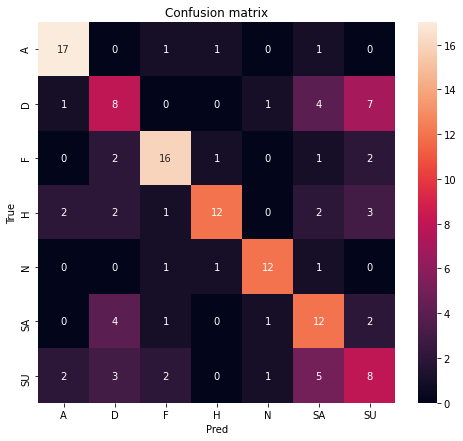

In [47]:
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(8, 7))
heatmap(cm, annot=True, xticklabels=idx_to_label.values(), yticklabels=idx_to_label.values())
plt.xlabel('Pred')
plt.ylabel('True')
plt.title('Confusion matrix');

<AxesSubplot:ylabel='Count'>

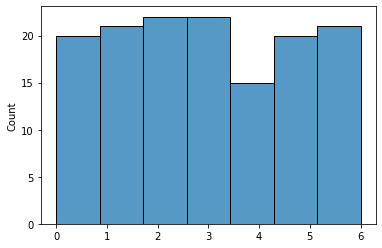

In [25]:
histplot(y_true_all, bins=7)